# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

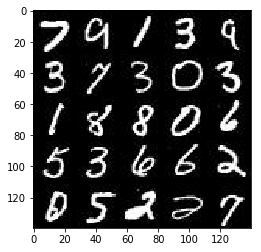

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

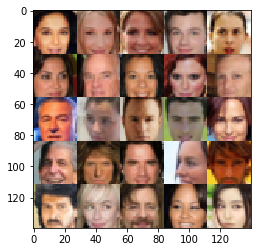

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_r = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),name="input_r")
    input_z = tf.placeholder(tf.float32, (None, z_dim),name="input_z")
    learning_r = tf.placeholder(tf.float32, None,name="learning_r")

    return input_r, input_z, learning_r


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        #28x28x3
        layer_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same",activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu_1 = tf.maximum(layer_1*alpha, layer_1)
        #14x14x64
        layer_2 = tf.layers.conv2d(relu_1, 128, 5, strides=2, padding="same", activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_2 = tf.layers.batch_normalization(layer_2, training=True)
        relu_2 = tf.maximum(bn_2*alpha, bn_2)
        #7x7x128
        layer_3 = tf.layers.conv2d(relu_2, 256, 5, strides=2, padding="same", activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_3 = tf.layers.batch_normalization(layer_3, training=True)
        relu_3=tf.maximum(bn_3*alpha, bn_3)
        #2x2x256
        flat = tf.reshape(relu_3,(-1, 4*4*256))
        logits = tf.layers.dense(flat,1)
        out=tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        l_0 = tf.layers.dense(z, 2*2*512)
        l_0 = tf.reshape(l_0, (-1,2,2,512))
        l_0 = tf.layers.batch_normalization(l_0, training=is_train)
        l_0 = tf.maximum(l_0*alpha, l_0)
        #2x2x256
        l_1 = tf.layers.conv2d_transpose(l_0, 256, 5, strides=2, padding="valid", activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        l_1 = tf.layers.batch_normalization(l_1, training=is_train)
        l_1 = tf.maximum(l_1*alpha, l_1)
        #7x7x128
        l_2 = tf.layers.conv2d_transpose(l_1, 128, 5, strides=2, padding="same", activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        l_2 = tf.layers.batch_normalization(l_2, training=is_train)
        l_2 = tf.maximum(l_2*alpha, l_2)    
        #14x14x64
        logits = tf.layers.conv2d_transpose(l_2, out_channel_dim, 5, strides=2, padding="same", activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - 0.1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_r, input_z, learning_r = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_r, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_r, beta1)

    steps = 0
    print_every=10
    show_every=100
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_r: batch_images, input_z: batch_z, learning_r:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_r: batch_images, learning_r:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_r: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    _ = show_generator_output(sess, 10,input_z, data_shape[3], data_image_mode)
                    

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9377... Generator Loss: 1.0340
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 1.6212
Epoch 1/2... Discriminator Loss: 0.4977... Generator Loss: 2.2436
Epoch 1/2... Discriminator Loss: 0.5570... Generator Loss: 1.9105
Epoch 1/2... Discriminator Loss: 0.4051... Generator Loss: 3.4012
Epoch 1/2... Discriminator Loss: 0.4547... Generator Loss: 3.1347
Epoch 1/2... Discriminator Loss: 0.5604... Generator Loss: 2.4967
Epoch 1/2... Discriminator Loss: 0.5731... Generator Loss: 4.0512
Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 0.7718
Epoch 1/2... Discriminator Loss: 0.5217... Generator Loss: 2.3010


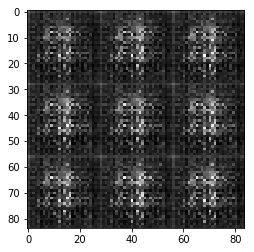

Epoch 1/2... Discriminator Loss: 0.6223... Generator Loss: 1.7247
Epoch 1/2... Discriminator Loss: 0.7532... Generator Loss: 4.7101
Epoch 1/2... Discriminator Loss: 0.5485... Generator Loss: 2.6094
Epoch 1/2... Discriminator Loss: 0.4505... Generator Loss: 2.9020
Epoch 1/2... Discriminator Loss: 0.4311... Generator Loss: 2.8546
Epoch 1/2... Discriminator Loss: 0.5113... Generator Loss: 2.4425
Epoch 1/2... Discriminator Loss: 0.4109... Generator Loss: 3.4492
Epoch 1/2... Discriminator Loss: 0.4048... Generator Loss: 3.3338
Epoch 1/2... Discriminator Loss: 0.4568... Generator Loss: 2.6250
Epoch 1/2... Discriminator Loss: 0.4734... Generator Loss: 2.4002


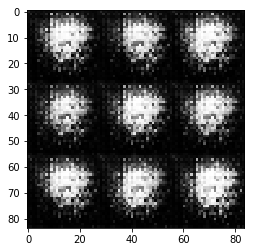

Epoch 1/2... Discriminator Loss: 0.6371... Generator Loss: 1.7015
Epoch 1/2... Discriminator Loss: 0.4429... Generator Loss: 2.7543
Epoch 1/2... Discriminator Loss: 0.4351... Generator Loss: 3.2070
Epoch 1/2... Discriminator Loss: 0.4774... Generator Loss: 2.5727
Epoch 1/2... Discriminator Loss: 0.4444... Generator Loss: 3.2332
Epoch 1/2... Discriminator Loss: 0.4591... Generator Loss: 2.8486
Epoch 1/2... Discriminator Loss: 0.4220... Generator Loss: 3.3325
Epoch 1/2... Discriminator Loss: 0.3745... Generator Loss: 4.3438
Epoch 1/2... Discriminator Loss: 0.4020... Generator Loss: 3.8152
Epoch 1/2... Discriminator Loss: 0.3701... Generator Loss: 4.1155


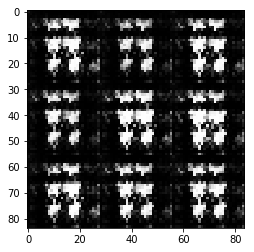

Epoch 1/2... Discriminator Loss: 0.3779... Generator Loss: 3.9009
Epoch 1/2... Discriminator Loss: 0.4392... Generator Loss: 2.7245
Epoch 1/2... Discriminator Loss: 0.3943... Generator Loss: 3.1188
Epoch 1/2... Discriminator Loss: 0.3717... Generator Loss: 3.7101
Epoch 1/2... Discriminator Loss: 0.3801... Generator Loss: 3.3708
Epoch 1/2... Discriminator Loss: 0.3954... Generator Loss: 3.7726
Epoch 1/2... Discriminator Loss: 0.4687... Generator Loss: 2.6449
Epoch 1/2... Discriminator Loss: 0.3844... Generator Loss: 4.2369
Epoch 1/2... Discriminator Loss: 0.4101... Generator Loss: 3.1353
Epoch 1/2... Discriminator Loss: 0.4401... Generator Loss: 3.0752


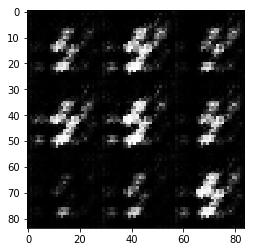

Epoch 1/2... Discriminator Loss: 0.4572... Generator Loss: 5.7393
Epoch 1/2... Discriminator Loss: 0.4802... Generator Loss: 2.8077
Epoch 1/2... Discriminator Loss: 0.4300... Generator Loss: 3.2616
Epoch 1/2... Discriminator Loss: 0.4384... Generator Loss: 2.8455
Epoch 1/2... Discriminator Loss: 0.4251... Generator Loss: 3.2907
Epoch 1/2... Discriminator Loss: 0.3864... Generator Loss: 4.2534
Epoch 1/2... Discriminator Loss: 0.4408... Generator Loss: 2.8283
Epoch 1/2... Discriminator Loss: 0.4192... Generator Loss: 3.8552
Epoch 1/2... Discriminator Loss: 0.5243... Generator Loss: 2.9964
Epoch 1/2... Discriminator Loss: 0.5035... Generator Loss: 3.2432


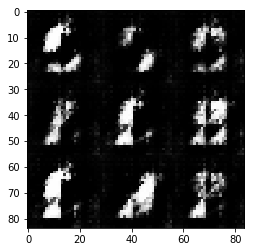

Epoch 1/2... Discriminator Loss: 0.6592... Generator Loss: 1.6420
Epoch 1/2... Discriminator Loss: 0.4976... Generator Loss: 2.9889
Epoch 1/2... Discriminator Loss: 0.5160... Generator Loss: 2.4138
Epoch 1/2... Discriminator Loss: 0.4375... Generator Loss: 3.5690
Epoch 1/2... Discriminator Loss: 0.4689... Generator Loss: 2.5165
Epoch 1/2... Discriminator Loss: 0.5397... Generator Loss: 3.8853
Epoch 1/2... Discriminator Loss: 0.6046... Generator Loss: 5.6835
Epoch 1/2... Discriminator Loss: 0.5807... Generator Loss: 2.3616
Epoch 1/2... Discriminator Loss: 0.4399... Generator Loss: 3.2979
Epoch 1/2... Discriminator Loss: 0.4602... Generator Loss: 3.1074


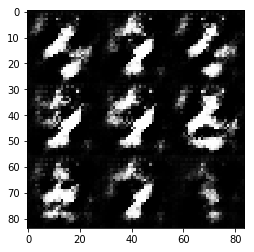

Epoch 1/2... Discriminator Loss: 0.4716... Generator Loss: 3.6105
Epoch 1/2... Discriminator Loss: 0.5179... Generator Loss: 2.4292
Epoch 1/2... Discriminator Loss: 0.4394... Generator Loss: 4.4465
Epoch 1/2... Discriminator Loss: 0.5034... Generator Loss: 2.3773
Epoch 1/2... Discriminator Loss: 0.7543... Generator Loss: 1.5393
Epoch 1/2... Discriminator Loss: 0.7153... Generator Loss: 4.2697
Epoch 1/2... Discriminator Loss: 0.6530... Generator Loss: 3.2068
Epoch 1/2... Discriminator Loss: 0.9901... Generator Loss: 4.4836
Epoch 1/2... Discriminator Loss: 0.5898... Generator Loss: 2.0078
Epoch 1/2... Discriminator Loss: 0.6727... Generator Loss: 2.7399


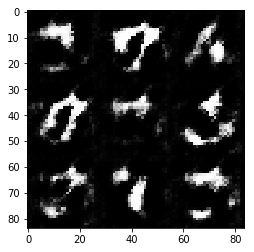

Epoch 1/2... Discriminator Loss: 0.4440... Generator Loss: 3.2234
Epoch 1/2... Discriminator Loss: 0.5105... Generator Loss: 2.5587
Epoch 1/2... Discriminator Loss: 0.5225... Generator Loss: 3.3141
Epoch 1/2... Discriminator Loss: 0.4731... Generator Loss: 2.9781
Epoch 1/2... Discriminator Loss: 0.5719... Generator Loss: 2.8460
Epoch 1/2... Discriminator Loss: 0.6804... Generator Loss: 3.7544
Epoch 1/2... Discriminator Loss: 0.6629... Generator Loss: 1.8096
Epoch 1/2... Discriminator Loss: 0.5933... Generator Loss: 2.0414
Epoch 1/2... Discriminator Loss: 0.6392... Generator Loss: 1.7975
Epoch 1/2... Discriminator Loss: 1.7567... Generator Loss: 5.3425


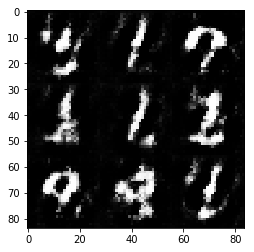

Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 2.7554
Epoch 1/2... Discriminator Loss: 0.5312... Generator Loss: 2.5303
Epoch 1/2... Discriminator Loss: 0.8929... Generator Loss: 1.1401
Epoch 1/2... Discriminator Loss: 0.6810... Generator Loss: 1.7576
Epoch 1/2... Discriminator Loss: 0.6140... Generator Loss: 2.7279
Epoch 1/2... Discriminator Loss: 0.6429... Generator Loss: 2.2762
Epoch 1/2... Discriminator Loss: 0.7631... Generator Loss: 1.5342
Epoch 1/2... Discriminator Loss: 0.6171... Generator Loss: 2.7766
Epoch 1/2... Discriminator Loss: 0.5602... Generator Loss: 2.3749
Epoch 1/2... Discriminator Loss: 0.6187... Generator Loss: 2.2530


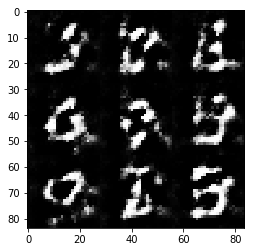

Epoch 1/2... Discriminator Loss: 0.6934... Generator Loss: 1.5717
Epoch 1/2... Discriminator Loss: 0.9197... Generator Loss: 3.0037
Epoch 1/2... Discriminator Loss: 0.9451... Generator Loss: 1.0212
Epoch 1/2... Discriminator Loss: 0.5787... Generator Loss: 2.0831
Epoch 1/2... Discriminator Loss: 0.6955... Generator Loss: 1.5662
Epoch 1/2... Discriminator Loss: 0.6525... Generator Loss: 1.9355
Epoch 1/2... Discriminator Loss: 0.8115... Generator Loss: 1.2706
Epoch 1/2... Discriminator Loss: 0.6788... Generator Loss: 2.0823
Epoch 1/2... Discriminator Loss: 0.5521... Generator Loss: 2.1066
Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 1.2902


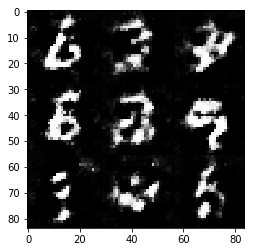

Epoch 1/2... Discriminator Loss: 0.6196... Generator Loss: 2.4347
Epoch 1/2... Discriminator Loss: 0.8721... Generator Loss: 1.1832
Epoch 1/2... Discriminator Loss: 0.5989... Generator Loss: 2.7046
Epoch 1/2... Discriminator Loss: 0.7128... Generator Loss: 1.5860
Epoch 1/2... Discriminator Loss: 0.6352... Generator Loss: 2.0730
Epoch 1/2... Discriminator Loss: 0.6328... Generator Loss: 2.0104
Epoch 1/2... Discriminator Loss: 0.6193... Generator Loss: 1.8261
Epoch 1/2... Discriminator Loss: 0.7991... Generator Loss: 2.4007
Epoch 1/2... Discriminator Loss: 0.8409... Generator Loss: 1.1517
Epoch 1/2... Discriminator Loss: 0.7368... Generator Loss: 1.4567


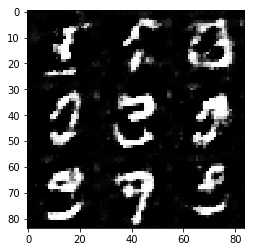

Epoch 1/2... Discriminator Loss: 0.6919... Generator Loss: 1.5815
Epoch 1/2... Discriminator Loss: 0.8305... Generator Loss: 2.6404
Epoch 1/2... Discriminator Loss: 0.6778... Generator Loss: 1.4700
Epoch 1/2... Discriminator Loss: 0.6557... Generator Loss: 1.7252
Epoch 1/2... Discriminator Loss: 0.6401... Generator Loss: 2.3184
Epoch 1/2... Discriminator Loss: 0.6778... Generator Loss: 1.7984
Epoch 1/2... Discriminator Loss: 0.6026... Generator Loss: 2.3695
Epoch 1/2... Discriminator Loss: 0.6193... Generator Loss: 1.9224
Epoch 1/2... Discriminator Loss: 0.7289... Generator Loss: 1.5691
Epoch 1/2... Discriminator Loss: 0.6894... Generator Loss: 1.5299


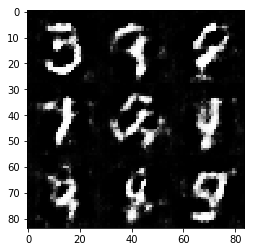

Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 1.3140
Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 0.8542
Epoch 1/2... Discriminator Loss: 0.7044... Generator Loss: 1.5972
Epoch 1/2... Discriminator Loss: 0.6908... Generator Loss: 2.2867
Epoch 1/2... Discriminator Loss: 0.6886... Generator Loss: 1.6170
Epoch 1/2... Discriminator Loss: 0.7095... Generator Loss: 1.4522
Epoch 1/2... Discriminator Loss: 0.6823... Generator Loss: 1.5950
Epoch 1/2... Discriminator Loss: 0.6758... Generator Loss: 2.2614
Epoch 1/2... Discriminator Loss: 1.4625... Generator Loss: 0.4985
Epoch 1/2... Discriminator Loss: 0.7898... Generator Loss: 2.6285


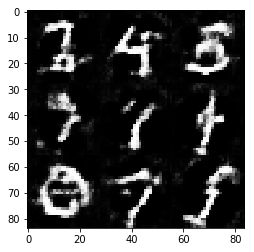

Epoch 1/2... Discriminator Loss: 0.8347... Generator Loss: 1.5611
Epoch 1/2... Discriminator Loss: 0.8643... Generator Loss: 2.5382
Epoch 1/2... Discriminator Loss: 1.1218... Generator Loss: 3.1811
Epoch 1/2... Discriminator Loss: 0.8113... Generator Loss: 1.4404
Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 0.6036
Epoch 1/2... Discriminator Loss: 0.7979... Generator Loss: 1.2720
Epoch 1/2... Discriminator Loss: 0.7376... Generator Loss: 1.8201
Epoch 1/2... Discriminator Loss: 0.7270... Generator Loss: 1.8989
Epoch 1/2... Discriminator Loss: 0.8398... Generator Loss: 1.0694
Epoch 1/2... Discriminator Loss: 0.6739... Generator Loss: 1.6278


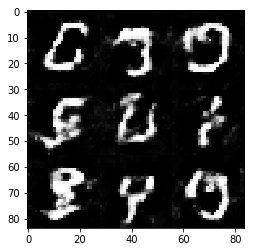

Epoch 1/2... Discriminator Loss: 0.7159... Generator Loss: 1.4500
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.2493
Epoch 1/2... Discriminator Loss: 0.7397... Generator Loss: 1.3946
Epoch 1/2... Discriminator Loss: 0.7372... Generator Loss: 1.3730
Epoch 1/2... Discriminator Loss: 0.7351... Generator Loss: 1.4083
Epoch 1/2... Discriminator Loss: 0.8656... Generator Loss: 1.1033
Epoch 1/2... Discriminator Loss: 1.1070... Generator Loss: 2.4126
Epoch 1/2... Discriminator Loss: 0.6967... Generator Loss: 1.4739
Epoch 1/2... Discriminator Loss: 0.8281... Generator Loss: 1.4390
Epoch 1/2... Discriminator Loss: 0.7484... Generator Loss: 1.4059


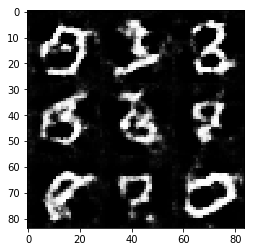

Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 1.4731
Epoch 1/2... Discriminator Loss: 0.7649... Generator Loss: 1.5158
Epoch 1/2... Discriminator Loss: 0.8534... Generator Loss: 1.1804
Epoch 1/2... Discriminator Loss: 0.8275... Generator Loss: 2.5097
Epoch 1/2... Discriminator Loss: 0.7847... Generator Loss: 1.4190
Epoch 1/2... Discriminator Loss: 0.7626... Generator Loss: 2.2928
Epoch 1/2... Discriminator Loss: 0.6924... Generator Loss: 1.6462
Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 1.3469
Epoch 1/2... Discriminator Loss: 0.6824... Generator Loss: 1.7079
Epoch 1/2... Discriminator Loss: 0.7433... Generator Loss: 1.9518


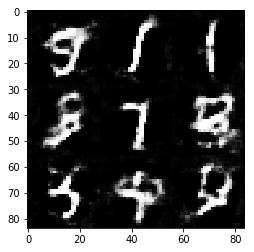

Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 1.4885
Epoch 1/2... Discriminator Loss: 0.7836... Generator Loss: 1.2041
Epoch 1/2... Discriminator Loss: 0.6683... Generator Loss: 1.7298
Epoch 1/2... Discriminator Loss: 0.8190... Generator Loss: 1.1973
Epoch 1/2... Discriminator Loss: 0.7275... Generator Loss: 1.4827
Epoch 1/2... Discriminator Loss: 0.6397... Generator Loss: 1.7885
Epoch 1/2... Discriminator Loss: 0.8114... Generator Loss: 1.2341
Epoch 1/2... Discriminator Loss: 0.7644... Generator Loss: 2.0303
Epoch 1/2... Discriminator Loss: 0.9888... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 0.7713... Generator Loss: 1.1676


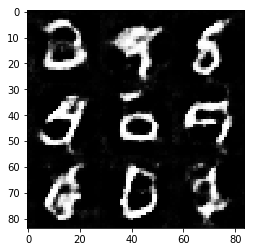

Epoch 1/2... Discriminator Loss: 0.6846... Generator Loss: 2.1433
Epoch 1/2... Discriminator Loss: 0.9385... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 0.5984... Generator Loss: 2.0691
Epoch 1/2... Discriminator Loss: 0.7061... Generator Loss: 1.6562
Epoch 1/2... Discriminator Loss: 0.7435... Generator Loss: 1.7679
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 0.8932
Epoch 1/2... Discriminator Loss: 0.6854... Generator Loss: 1.5630
Epoch 1/2... Discriminator Loss: 0.7501... Generator Loss: 1.4207
Epoch 1/2... Discriminator Loss: 0.8066... Generator Loss: 1.3164
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 0.9298


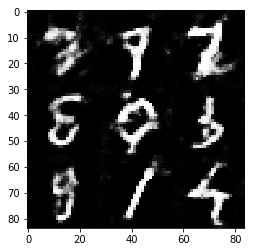

Epoch 1/2... Discriminator Loss: 0.7727... Generator Loss: 1.5330
Epoch 1/2... Discriminator Loss: 0.6947... Generator Loss: 1.6687
Epoch 1/2... Discriminator Loss: 0.7949... Generator Loss: 1.3782
Epoch 1/2... Discriminator Loss: 0.7210... Generator Loss: 1.7807
Epoch 1/2... Discriminator Loss: 0.7093... Generator Loss: 1.2979
Epoch 1/2... Discriminator Loss: 0.7100... Generator Loss: 1.5007
Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 1.5659
Epoch 2/2... Discriminator Loss: 0.9952... Generator Loss: 0.8479
Epoch 2/2... Discriminator Loss: 0.9751... Generator Loss: 2.9212
Epoch 2/2... Discriminator Loss: 0.6753... Generator Loss: 1.5759


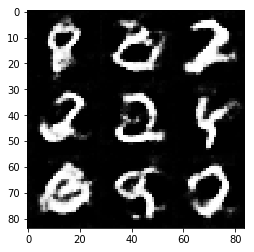

Epoch 2/2... Discriminator Loss: 0.6595... Generator Loss: 1.5691
Epoch 2/2... Discriminator Loss: 0.7683... Generator Loss: 1.3832
Epoch 2/2... Discriminator Loss: 0.8639... Generator Loss: 2.4923
Epoch 2/2... Discriminator Loss: 0.7189... Generator Loss: 1.6562
Epoch 2/2... Discriminator Loss: 0.7777... Generator Loss: 1.7724
Epoch 2/2... Discriminator Loss: 0.6464... Generator Loss: 1.5677
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.0641
Epoch 2/2... Discriminator Loss: 1.2175... Generator Loss: 0.6808
Epoch 2/2... Discriminator Loss: 0.7424... Generator Loss: 1.3397
Epoch 2/2... Discriminator Loss: 0.7757... Generator Loss: 1.7663


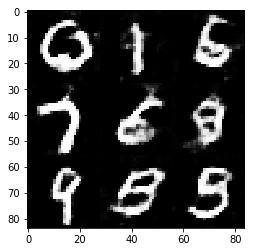

Epoch 2/2... Discriminator Loss: 0.7036... Generator Loss: 1.9843
Epoch 2/2... Discriminator Loss: 0.6342... Generator Loss: 1.9927
Epoch 2/2... Discriminator Loss: 0.5813... Generator Loss: 2.4644
Epoch 2/2... Discriminator Loss: 0.6648... Generator Loss: 2.1054
Epoch 2/2... Discriminator Loss: 1.1431... Generator Loss: 0.7393
Epoch 2/2... Discriminator Loss: 0.7123... Generator Loss: 1.6532
Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.6645
Epoch 2/2... Discriminator Loss: 0.7155... Generator Loss: 1.4805
Epoch 2/2... Discriminator Loss: 0.7399... Generator Loss: 1.4043
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 0.6881


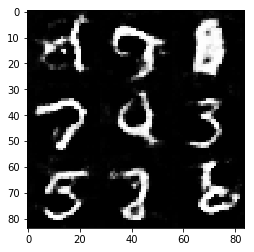

Epoch 2/2... Discriminator Loss: 0.7564... Generator Loss: 1.9697
Epoch 2/2... Discriminator Loss: 0.7642... Generator Loss: 1.3078
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 1.9487
Epoch 2/2... Discriminator Loss: 1.0783... Generator Loss: 0.9107
Epoch 2/2... Discriminator Loss: 0.8019... Generator Loss: 1.1702
Epoch 2/2... Discriminator Loss: 0.8381... Generator Loss: 2.1909
Epoch 2/2... Discriminator Loss: 1.2182... Generator Loss: 0.6670
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 0.6938
Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 2.1809
Epoch 2/2... Discriminator Loss: 0.7564... Generator Loss: 1.4471


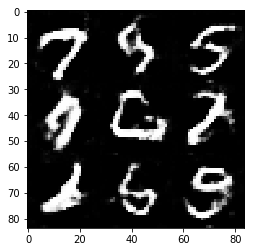

Epoch 2/2... Discriminator Loss: 0.7327... Generator Loss: 1.5563
Epoch 2/2... Discriminator Loss: 0.8822... Generator Loss: 1.0774
Epoch 2/2... Discriminator Loss: 1.0330... Generator Loss: 0.8593
Epoch 2/2... Discriminator Loss: 0.7689... Generator Loss: 1.3031
Epoch 2/2... Discriminator Loss: 0.7269... Generator Loss: 1.3217
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 0.9816
Epoch 2/2... Discriminator Loss: 0.7457... Generator Loss: 2.2274
Epoch 2/2... Discriminator Loss: 0.7503... Generator Loss: 1.7906
Epoch 2/2... Discriminator Loss: 0.6460... Generator Loss: 1.6869
Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 1.5493


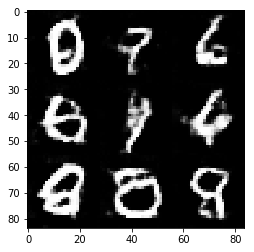

Epoch 2/2... Discriminator Loss: 0.8036... Generator Loss: 1.7293
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.1904
Epoch 2/2... Discriminator Loss: 0.8196... Generator Loss: 1.1599
Epoch 2/2... Discriminator Loss: 0.7344... Generator Loss: 1.4336
Epoch 2/2... Discriminator Loss: 0.7921... Generator Loss: 2.1650
Epoch 2/2... Discriminator Loss: 0.9814... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 0.6806... Generator Loss: 1.4833
Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.8901
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 1.1239
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.7223


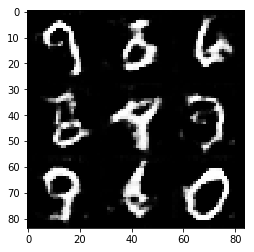

Epoch 2/2... Discriminator Loss: 0.7865... Generator Loss: 1.2539
Epoch 2/2... Discriminator Loss: 0.6110... Generator Loss: 1.8022
Epoch 2/2... Discriminator Loss: 0.8278... Generator Loss: 1.1305
Epoch 2/2... Discriminator Loss: 0.8176... Generator Loss: 1.1579
Epoch 2/2... Discriminator Loss: 0.6321... Generator Loss: 1.6818
Epoch 2/2... Discriminator Loss: 0.8456... Generator Loss: 1.1043
Epoch 2/2... Discriminator Loss: 0.6552... Generator Loss: 1.8973
Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 2.3771
Epoch 2/2... Discriminator Loss: 0.6523... Generator Loss: 1.6748
Epoch 2/2... Discriminator Loss: 0.8250... Generator Loss: 1.1512


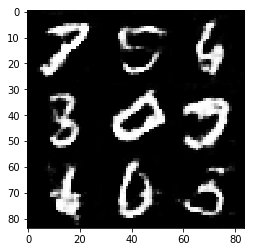

Epoch 2/2... Discriminator Loss: 1.1524... Generator Loss: 0.7017
Epoch 2/2... Discriminator Loss: 0.5490... Generator Loss: 2.0250
Epoch 2/2... Discriminator Loss: 0.8343... Generator Loss: 1.1096
Epoch 2/2... Discriminator Loss: 0.8348... Generator Loss: 1.0643
Epoch 2/2... Discriminator Loss: 0.7827... Generator Loss: 1.7471
Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 2.2461
Epoch 2/2... Discriminator Loss: 0.6333... Generator Loss: 1.6523
Epoch 2/2... Discriminator Loss: 0.6324... Generator Loss: 1.8270
Epoch 2/2... Discriminator Loss: 0.7390... Generator Loss: 1.3239
Epoch 2/2... Discriminator Loss: 0.7931... Generator Loss: 1.2165


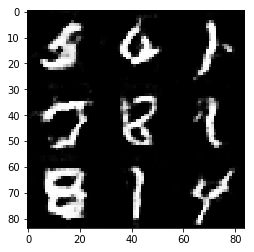

Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 1.5502
Epoch 2/2... Discriminator Loss: 0.7471... Generator Loss: 1.2781
Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 0.6202
Epoch 2/2... Discriminator Loss: 0.5827... Generator Loss: 1.9051
Epoch 2/2... Discriminator Loss: 0.7539... Generator Loss: 1.3748
Epoch 2/2... Discriminator Loss: 0.6210... Generator Loss: 1.7351
Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 0.5516
Epoch 2/2... Discriminator Loss: 0.6783... Generator Loss: 1.7036
Epoch 2/2... Discriminator Loss: 0.5642... Generator Loss: 1.9713
Epoch 2/2... Discriminator Loss: 0.6555... Generator Loss: 1.7366


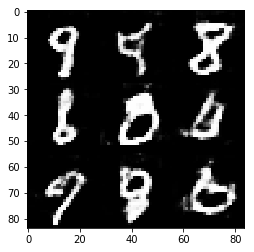

Epoch 2/2... Discriminator Loss: 0.7049... Generator Loss: 1.4988
Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 0.9807
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 2.2927
Epoch 2/2... Discriminator Loss: 0.7371... Generator Loss: 1.3038
Epoch 2/2... Discriminator Loss: 0.6757... Generator Loss: 1.7471
Epoch 2/2... Discriminator Loss: 0.6162... Generator Loss: 2.5760
Epoch 2/2... Discriminator Loss: 1.0436... Generator Loss: 1.0309
Epoch 2/2... Discriminator Loss: 0.8571... Generator Loss: 1.0876
Epoch 2/2... Discriminator Loss: 0.6056... Generator Loss: 1.7415
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 1.1175


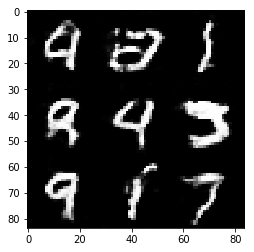

Epoch 2/2... Discriminator Loss: 0.6307... Generator Loss: 1.8342
Epoch 2/2... Discriminator Loss: 0.6123... Generator Loss: 1.6237
Epoch 2/2... Discriminator Loss: 0.5776... Generator Loss: 2.0893
Epoch 2/2... Discriminator Loss: 0.8006... Generator Loss: 1.1816
Epoch 2/2... Discriminator Loss: 0.5697... Generator Loss: 2.0367
Epoch 2/2... Discriminator Loss: 0.6826... Generator Loss: 1.3783
Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 1.5761
Epoch 2/2... Discriminator Loss: 0.7111... Generator Loss: 1.3627
Epoch 2/2... Discriminator Loss: 0.7869... Generator Loss: 1.2846
Epoch 2/2... Discriminator Loss: 0.6543... Generator Loss: 1.6477


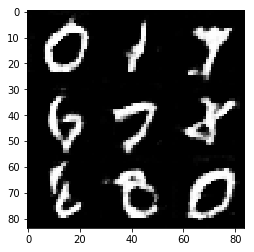

Epoch 2/2... Discriminator Loss: 1.1073... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 1.2031
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 1.0924
Epoch 2/2... Discriminator Loss: 0.8045... Generator Loss: 1.1671
Epoch 2/2... Discriminator Loss: 0.7814... Generator Loss: 1.2184
Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 3.1755
Epoch 2/2... Discriminator Loss: 0.7204... Generator Loss: 1.4366
Epoch 2/2... Discriminator Loss: 0.6802... Generator Loss: 1.4380
Epoch 2/2... Discriminator Loss: 0.9948... Generator Loss: 0.8728
Epoch 2/2... Discriminator Loss: 0.7796... Generator Loss: 1.1778


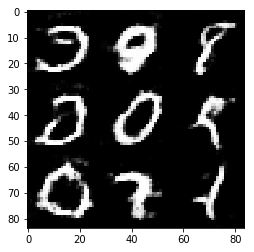

Epoch 2/2... Discriminator Loss: 0.6551... Generator Loss: 1.5352
Epoch 2/2... Discriminator Loss: 0.7900... Generator Loss: 1.1798
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 0.7669
Epoch 2/2... Discriminator Loss: 0.8571... Generator Loss: 1.0896
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 1.0334
Epoch 2/2... Discriminator Loss: 0.6807... Generator Loss: 1.4429
Epoch 2/2... Discriminator Loss: 1.2231... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 0.7403... Generator Loss: 1.3290
Epoch 2/2... Discriminator Loss: 0.5435... Generator Loss: 2.1406
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.5425


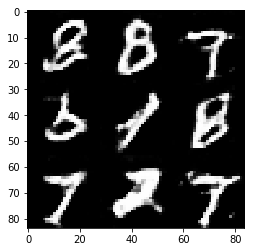

Epoch 2/2... Discriminator Loss: 0.6714... Generator Loss: 1.4498
Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 1.2076
Epoch 2/2... Discriminator Loss: 0.6579... Generator Loss: 1.6911
Epoch 2/2... Discriminator Loss: 0.6391... Generator Loss: 2.2595
Epoch 2/2... Discriminator Loss: 1.0740... Generator Loss: 0.8820
Epoch 2/2... Discriminator Loss: 0.6495... Generator Loss: 1.7891
Epoch 2/2... Discriminator Loss: 0.7519... Generator Loss: 1.2740
Epoch 2/2... Discriminator Loss: 0.5793... Generator Loss: 1.8025
Epoch 2/2... Discriminator Loss: 1.0509... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 1.2058... Generator Loss: 0.7292


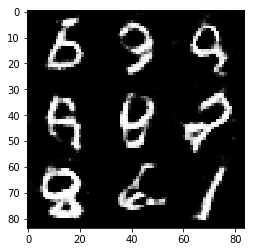

Epoch 2/2... Discriminator Loss: 1.5731... Generator Loss: 0.4115
Epoch 2/2... Discriminator Loss: 0.7054... Generator Loss: 1.6596
Epoch 2/2... Discriminator Loss: 0.6650... Generator Loss: 1.6285
Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 1.3893
Epoch 2/2... Discriminator Loss: 0.7175... Generator Loss: 1.4668
Epoch 2/2... Discriminator Loss: 0.8155... Generator Loss: 1.1880
Epoch 2/2... Discriminator Loss: 0.7113... Generator Loss: 1.5709
Epoch 2/2... Discriminator Loss: 0.6007... Generator Loss: 2.4863
Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 2.0236
Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 0.9660


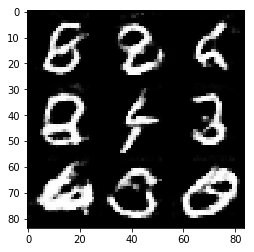

Epoch 2/2... Discriminator Loss: 1.0453... Generator Loss: 0.7710
Epoch 2/2... Discriminator Loss: 0.6505... Generator Loss: 1.6326
Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 1.1180
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 0.9070
Epoch 2/2... Discriminator Loss: 0.6954... Generator Loss: 1.6714
Epoch 2/2... Discriminator Loss: 0.7807... Generator Loss: 1.2747
Epoch 2/2... Discriminator Loss: 1.0966... Generator Loss: 0.7845
Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 1.7049
Epoch 2/2... Discriminator Loss: 0.7060... Generator Loss: 1.3737
Epoch 2/2... Discriminator Loss: 0.6026... Generator Loss: 1.5400


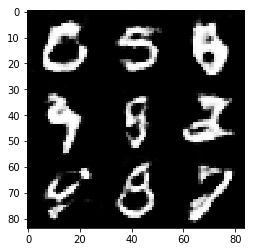

Epoch 2/2... Discriminator Loss: 0.9495... Generator Loss: 0.9625
Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 1.5090
Epoch 2/2... Discriminator Loss: 0.5654... Generator Loss: 1.8030
Epoch 2/2... Discriminator Loss: 0.5975... Generator Loss: 1.7032
Epoch 2/2... Discriminator Loss: 0.9667... Generator Loss: 0.8837
Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 1.7579
Epoch 2/2... Discriminator Loss: 0.8101... Generator Loss: 1.1710
Epoch 2/2... Discriminator Loss: 0.8214... Generator Loss: 1.1395
Epoch 2/2... Discriminator Loss: 0.4594... Generator Loss: 2.5610
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.0852


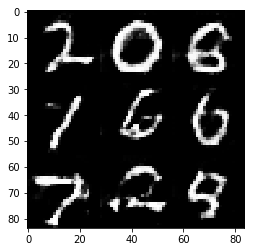

Epoch 2/2... Discriminator Loss: 0.7826... Generator Loss: 1.2377
Epoch 2/2... Discriminator Loss: 0.5632... Generator Loss: 1.9034
Epoch 2/2... Discriminator Loss: 1.5432... Generator Loss: 3.5245
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.6160
Epoch 2/2... Discriminator Loss: 0.8060... Generator Loss: 1.1566
Epoch 2/2... Discriminator Loss: 0.7317... Generator Loss: 1.2753
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.3531
Epoch 2/2... Discriminator Loss: 0.7554... Generator Loss: 1.8060
Epoch 2/2... Discriminator Loss: 0.7121... Generator Loss: 1.3995
Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 1.5614


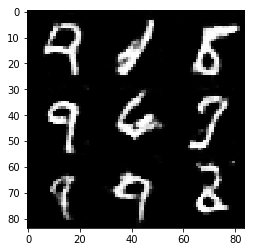

Epoch 2/2... Discriminator Loss: 1.0241... Generator Loss: 0.8459
Epoch 2/2... Discriminator Loss: 0.6589... Generator Loss: 1.4221
Epoch 2/2... Discriminator Loss: 0.6821... Generator Loss: 1.8737
Epoch 2/2... Discriminator Loss: 0.6561... Generator Loss: 1.5296
Epoch 2/2... Discriminator Loss: 0.7762... Generator Loss: 1.1789
Epoch 2/2... Discriminator Loss: 0.7066... Generator Loss: 1.2966
Epoch 2/2... Discriminator Loss: 0.6467... Generator Loss: 1.6832
Epoch 2/2... Discriminator Loss: 0.9242... Generator Loss: 0.9598
Epoch 2/2... Discriminator Loss: 0.5323... Generator Loss: 2.1729
Epoch 2/2... Discriminator Loss: 0.6623... Generator Loss: 1.5271


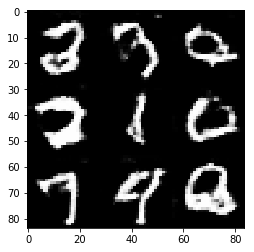

Epoch 2/2... Discriminator Loss: 0.6679... Generator Loss: 1.4675
Epoch 2/2... Discriminator Loss: 0.9278... Generator Loss: 0.9564
Epoch 2/2... Discriminator Loss: 1.0359... Generator Loss: 0.8094
Epoch 2/2... Discriminator Loss: 0.8728... Generator Loss: 1.0982
Epoch 2/2... Discriminator Loss: 0.6248... Generator Loss: 1.5590


In [18]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7387... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.7113
Epoch 1/1... Discriminator Loss: 0.6362... Generator Loss: 1.6573
Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 2.8269
Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 2.4052
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 2.3222
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 1.7741
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 1.9006
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 2.7305


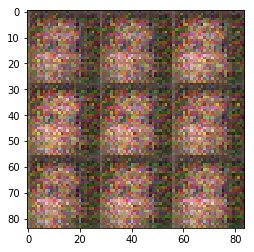

Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 1.6803
Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 2.1726
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 2.0099
Epoch 1/1... Discriminator Loss: 0.5358... Generator Loss: 2.9027
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 2.1378
Epoch 1/1... Discriminator Loss: 0.4439... Generator Loss: 2.6352
Epoch 1/1... Discriminator Loss: 0.4462... Generator Loss: 2.7422
Epoch 1/1... Discriminator Loss: 0.4296... Generator Loss: 3.1314
Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 2.8052


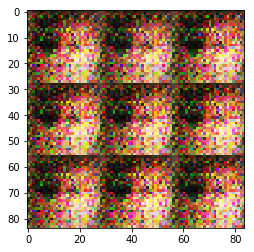

Epoch 1/1... Discriminator Loss: 0.4077... Generator Loss: 3.2260
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 3.1743
Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 2.8703
Epoch 1/1... Discriminator Loss: 0.4067... Generator Loss: 3.3921
Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 3.9263
Epoch 1/1... Discriminator Loss: 0.4531... Generator Loss: 2.3466
Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 2.9873
Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 4.2865
Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 3.9491
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 3.2474


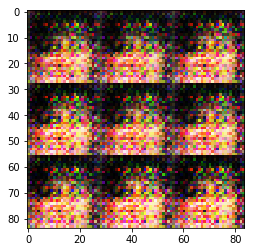

Epoch 1/1... Discriminator Loss: 0.4267... Generator Loss: 2.8106
Epoch 1/1... Discriminator Loss: 0.4398... Generator Loss: 2.8249
Epoch 1/1... Discriminator Loss: 0.4451... Generator Loss: 3.0471
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 2.8047
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 2.9244
Epoch 1/1... Discriminator Loss: 0.3961... Generator Loss: 3.2370
Epoch 1/1... Discriminator Loss: 0.5727... Generator Loss: 2.6292
Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 2.6996
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 2.1547
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.8749


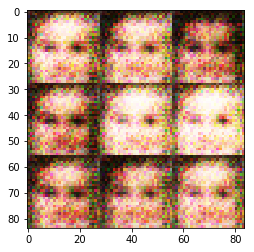

Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 2.0389
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 2.7512
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 2.4404
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 3.1795
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 4.3642
Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 3.0471
Epoch 1/1... Discriminator Loss: 0.6550... Generator Loss: 1.5309
Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 1.8289
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 1.7175
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.5480


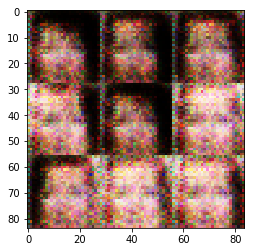

Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 2.3529
Epoch 1/1... Discriminator Loss: 0.7135... Generator Loss: 1.5113
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 1.6565
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 1.5673
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 3.0916
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 2.1818
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 1.3759
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.9400


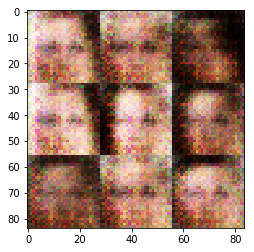

Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.1638
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.5333
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.6295
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.4842
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 1.2658
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 2.2696
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 2.0083
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 1.5644
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.2872


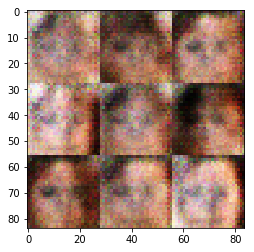

Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 1.4267
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.5480
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 3.0000
Epoch 1/1... Discriminator Loss: 0.6067... Generator Loss: 1.9618
Epoch 1/1... Discriminator Loss: 0.6231... Generator Loss: 1.6946
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.4891
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.2153


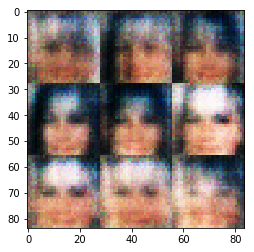

Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 2.2883
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.7795
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 2.5238
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 1.4355
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 1.0387
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 1.7526


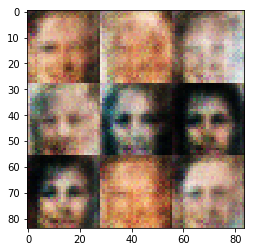

Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 1.7818
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.2795
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 2.0663
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 1.6453
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.3477


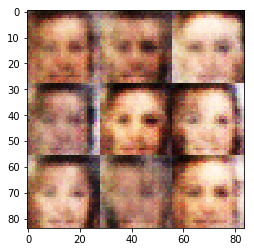

Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 1.1310
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 1.4907
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.4891
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.5245
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.3948
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 1.2355


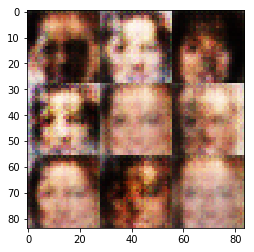

Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 1.2225
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.4621
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.4717
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.9501


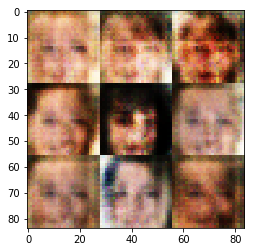

Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 1.1224
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6657


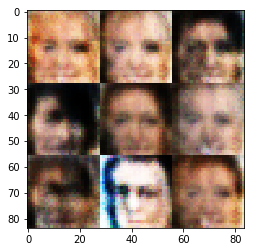

Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.4350
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.2553
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.2171
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.5674
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 1.1058


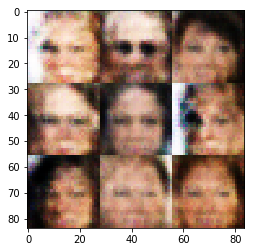

Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.4113
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.3370
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 1.3377
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.3765
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.8377


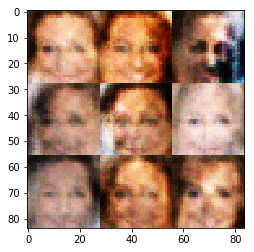

Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 1.0989
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.8479... Generator Loss: 0.3167
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.6386


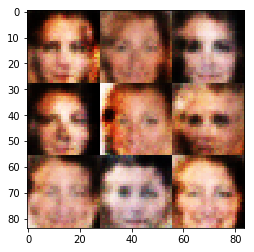

Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.1379
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 1.4209
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.1989
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 1.5392
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.6253


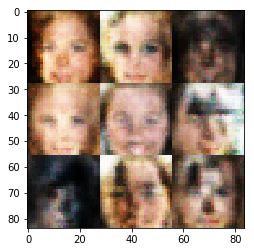

Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.0381
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.9755


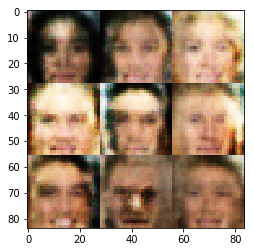

Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.2199
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.2299
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 0.9322


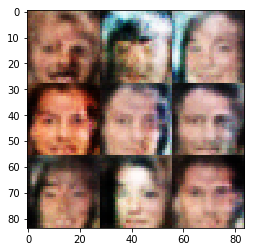

Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.2745


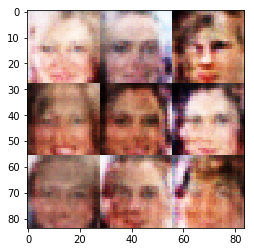

Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.2973
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.4654
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 1.4033
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.4127
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.5579


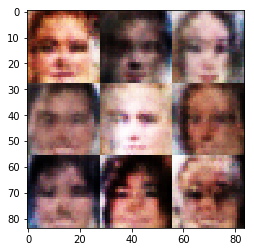

Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.2185
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 1.5723
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.8332


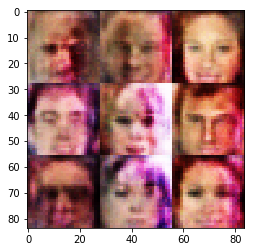

Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.4122
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.7802
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.4468
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 1.4867
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.0516


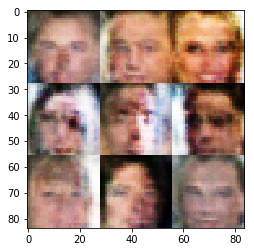

Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.3954
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 1.1730
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.6296
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 1.3000


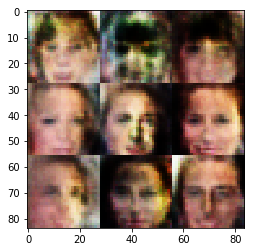

Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.1534
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 1.6848
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.1293
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.2444


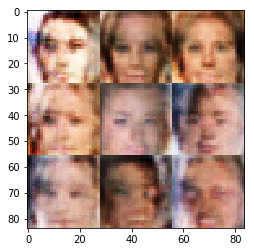

Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.6643
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 1.2078
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.8181


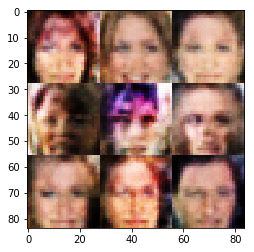

Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.1128
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.9888
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.0995
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 1.1936


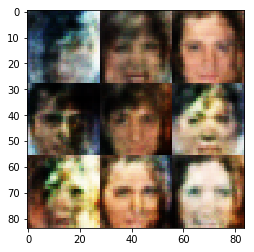

Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.0338
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 1.3742
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.3327
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.4076
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.1109


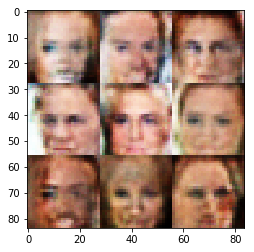

Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.0941
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 1.2540
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.8825


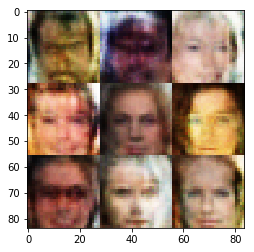

Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.3613
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 1.2961
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.5798
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 1.4989
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.7986


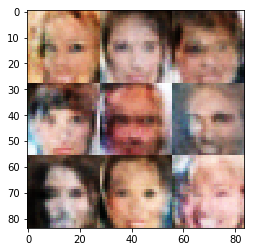

Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.1351
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.6300


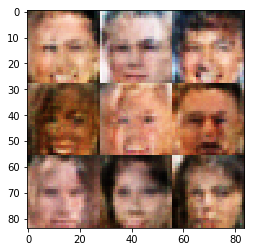

Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 1.5926
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 0.9999


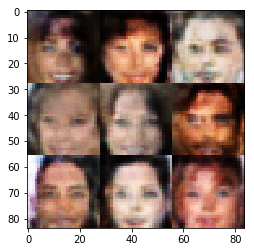

Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 1.2338
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.6446


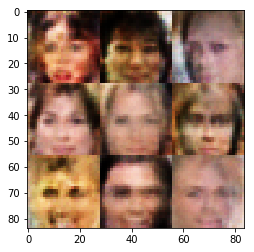

Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.5147
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.2681
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.0403


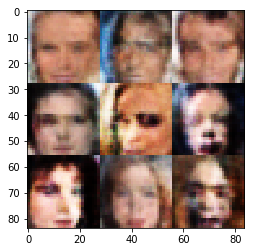

Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 1.1388
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.2183
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.2287
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 0.9987


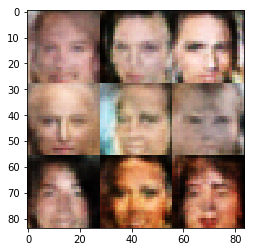

Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.9224


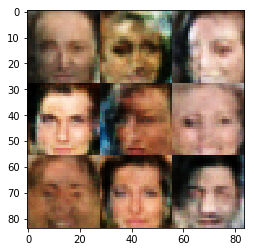

Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 1.4638
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.5241
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.9058


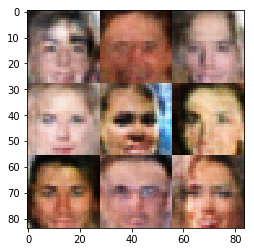

Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.3620
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.3431
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.2254
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 0.9187


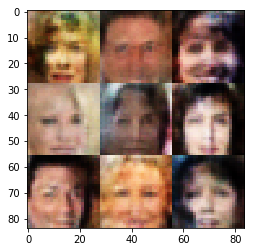

Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.4141
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.6703


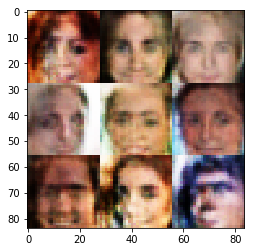

Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.3023
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.7741


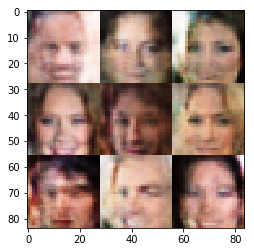

Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.4580
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.1079
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.9355


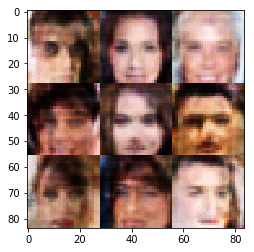

Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.5053
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.2097
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 1.0562


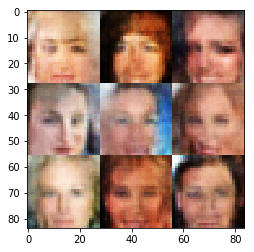

Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 1.1567
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.5211
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.8935


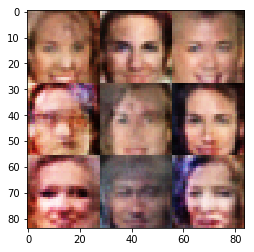

Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.3632
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 0.7226... Generator Loss: 1.9553
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.9127


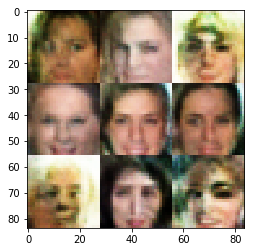

Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.2696
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.0678
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.6329


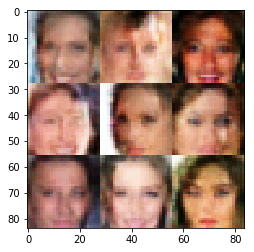

Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 0.7589... Generator Loss: 1.3690
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.7178


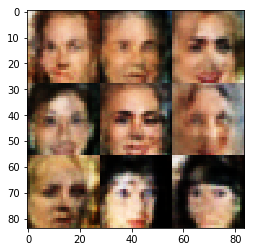

Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.3337
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.9625
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 1.2650
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 1.0935


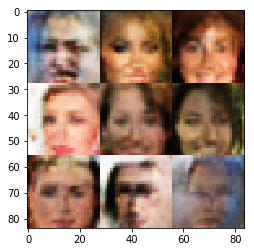

Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 1.1828
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.2814


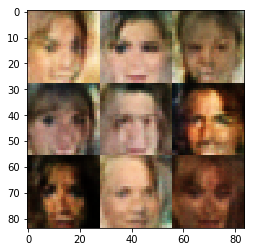

Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.3461
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 1.3599


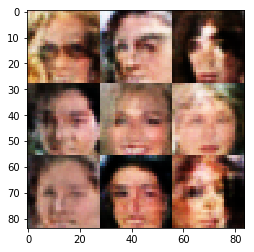

Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.0962
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.3974
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.7624


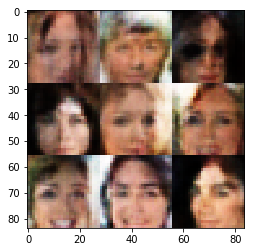

Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.4737
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 1.2775
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.7814


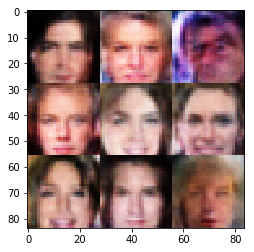

Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.1328
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 1.2699


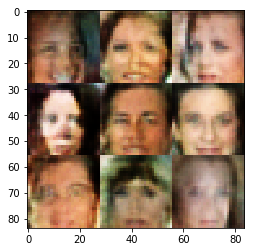

Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.1183
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.1973
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.1874
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.3642
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.0564


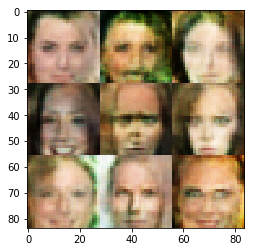

Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.4751
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.2673
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.4127
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.8587


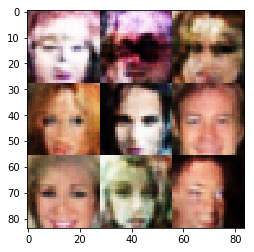

Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.3380
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.4903
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.6468
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 1.3350
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.3400
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.7685


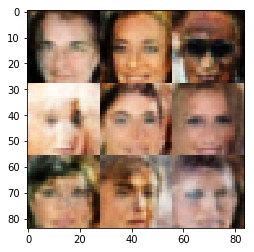

Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.4388
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.1907
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.1992
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.1745
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.9014


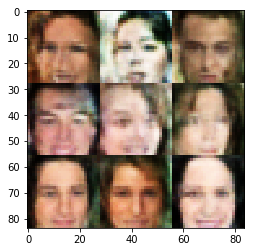

Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.3381
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 1.1977
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 1.1643


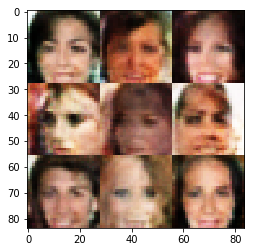

Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.1797
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 1.2842
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.8181


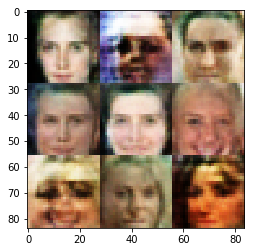

Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.2287
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.6468


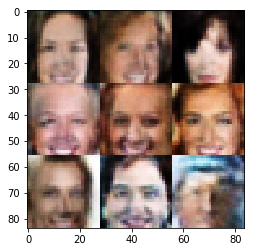

Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.2374
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 0.9189


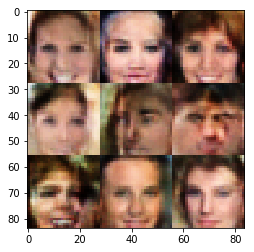

Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 0.7505... Generator Loss: 1.5266
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 1.3357
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 0.9665


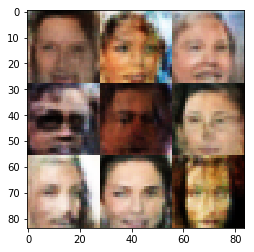

Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.5439


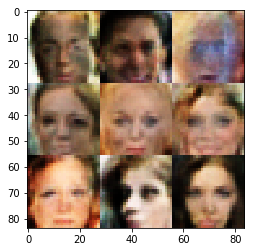

Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 1.0060
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 2.1622
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 1.6562
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.8170


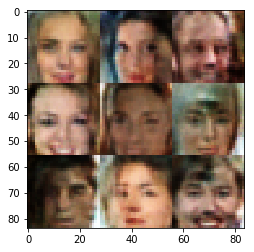

Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.2303


In [19]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.